In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import joblib

In [2]:
df_raw = pd.read_parquet("AvailabilityDataCombined.gzip")

#### with correct weather

In [3]:
df = df_raw.loc[df_raw["last_update"] > pd.to_datetime("2024-02-15 09:40:00")]

In [4]:
featuresList = ["number","last_update","available_bikes","banking","temp","feels_like","pressure","humidity","uvi","clouds","visibility","wind_speed","wind_deg","wind_gust","weather_main","rain","weather_description"]
df = df[featuresList]

In [5]:
X = df.drop(['available_bikes'], axis=1)
y = df['available_bikes']

# Convert 'last_update' to datetime and extract useful features
X['last_update'] = pd.to_datetime(X['last_update'])
X['hour'] = X['last_update'].dt.hour
X['day'] = X['last_update'].dt.day
X['month'] = X['last_update'].dt.month
X = X.drop(['last_update'], axis=1)

# Handling categorical variables and missing values
categorical_features = ["number",'weather_main', 'weather_description',"banking"]
numerical_features = X.drop(columns=categorical_features).columns

numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean'))
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, numerical_features),
        ('cat', categorical_pipeline, categorical_features)
    ])

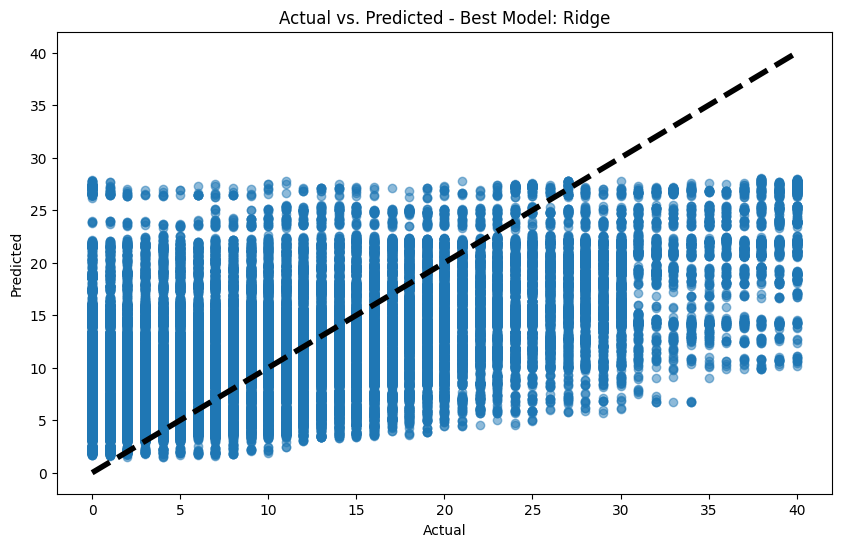

In [6]:
models = {
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'Linear Regression': LinearRegression()
}

model_pipelines = {}
for name, model in models.items():
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    model_pipelines[name] = pipeline

# Evaluate each model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model_scores = {}
for name, pipeline in model_pipelines.items():
    # Using negative MSE to make it easier to compare (higher is better)
    scores = cross_val_score(pipeline, X_train, y_train, scoring='neg_mean_squared_error', cv=3)
    model_scores[name] = scores.mean()

best_model_name = max(model_scores, key=model_scores.get)
best_pipeline = model_pipelines[best_model_name]

# Fit and predict using the best model
best_pipeline.fit(X_train, y_train)
y_pred = best_pipeline.predict(X_test)

# Visualization
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title(f'Actual vs. Predicted - Best Model: {best_model_name}')
plt.show()

In [10]:
joblib.dump(best_pipeline, 'BestModel.joblib') 

['BestModel.joblib']